Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [10]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import pandas as pd
%matplotlib inline

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)
    ).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data. 16 X 28 X 28 X 64
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels)
    )
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # layer 1: 5 X 5 X 1 X 16
    layer1_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1)
    )
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    # layer 2: 5 X 5 X 16 X 16
    layer2_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1)
    )
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    # layer 3: 784 X 64
    layer3_weights = tf.Variable(
        tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)
    )
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    # layer 4: 64 X 10
    layer4_weights = tf.Variable(
        tf.truncated_normal([num_hidden, num_labels], stddev=0.1)
    )
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    )

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 2.935992
Minibatch loss at step 50: 1.949321
Minibatch loss at step 100: 1.139719
Minibatch loss at step 150: 0.532707
Minibatch loss at step 200: 0.952258
Minibatch loss at step 250: 1.074901
Minibatch loss at step 300: 0.330282
Minibatch loss at step 350: 0.500142
Minibatch loss at step 400: 0.307414
Minibatch loss at step 450: 0.870688
Minibatch loss at step 500: 0.830350
Minibatch loss at step 550: 0.932541
Minibatch loss at step 600: 0.331828
Minibatch loss at step 650: 0.842991
Minibatch loss at step 700: 0.785157
Minibatch loss at step 750: 0.071751
Minibatch loss at step 800: 0.535936
Minibatch loss at step 850: 0.869091
Minibatch loss at step 900: 0.561618
Minibatch loss at step 950: 0.626249
Minibatch loss at step 1000: 0.509912
Test accuracy: 89.8%


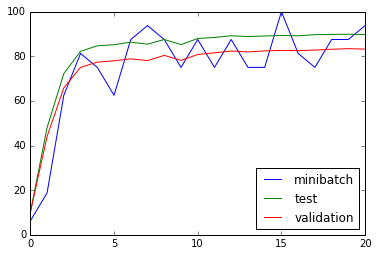

In [11]:
num_steps = 1001

results = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    print('Initialized')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction],
            feed_dict={
                tf_train_dataset : batch_data,
                tf_train_labels : batch_labels
            }
        )
        
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
#             print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
#             print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
            
            results.append({
                'minibatch': accuracy(predictions, batch_labels),
                'validation': accuracy(valid_prediction.eval(), valid_labels),
                'test': accuracy(test_prediction.eval(), test_labels)
            })
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    
results = pd.DataFrame(results)
results.plot()

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [42]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Input data. 16 X 28 X 28 X 64
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels)
    )
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # layer 1: 5 X 5 X 1 X 16
    layer1_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1)
    )
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    # layer 2: 5 X 5 X 16 X 16
    layer2_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1)
    )
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    # layer 3: 784 X 64
    layer3_weights = tf.Variable(
        tf.truncated_normal(
            [
                image_size // 4 * image_size // 4 * depth,
                num_hidden
            ],
            stddev=0.1
        )
    )
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    # layer 4: 64 X 10
    layer4_weights = tf.Variable(
        tf.truncated_normal([num_hidden, num_labels], stddev=0.1)
    )
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Model.
    def model(data):
        layer_1_conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        layer_1_bias = tf.nn.relu(layer_1_conv + layer1_biases)
        layer_1_pool = tf.nn.max_pool(layer_1_bias, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        layer_2_conv = tf.nn.conv2d(layer_1_pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        layer_2_bias = tf.nn.relu(layer_2_conv + layer2_biases)
        layer_2_pool = tf.nn.max_pool(layer_2_bias, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        shape = layer_2_pool.get_shape().as_list()
        reshape = tf.reshape(layer_2_pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 4.830544
Minibatch loss at step 50: 2.129334
Minibatch loss at step 100: 1.120768
Minibatch loss at step 150: 0.557522
Minibatch loss at step 200: 0.902621
Minibatch loss at step 250: 1.232588
Minibatch loss at step 300: 0.325561
Minibatch loss at step 350: 0.539432
Minibatch loss at step 400: 0.253347
Minibatch loss at step 450: 1.041657
Minibatch loss at step 500: 0.693065
Minibatch loss at step 550: 0.741084
Minibatch loss at step 600: 0.281147
Minibatch loss at step 650: 0.902224
Minibatch loss at step 700: 0.951131
Minibatch loss at step 750: 0.045431
Minibatch loss at step 800: 0.685543
Minibatch loss at step 850: 0.958092
Minibatch loss at step 900: 0.651034
Minibatch loss at step 950: 0.610479
Minibatch loss at step 1000: 0.349168
Test accuracy: 90.2%


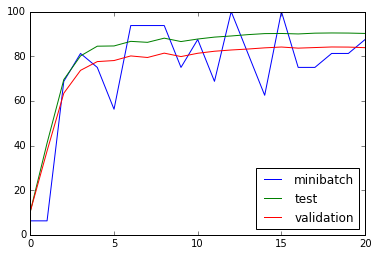

In [43]:
num_steps = 1001

results = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    print('Initialized')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction],
            feed_dict={
                tf_train_dataset : batch_data,
                tf_train_labels : batch_labels
            }
        )
        
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
#             print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
#             print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
            
            results.append({
                'minibatch': accuracy(predictions, batch_labels),
                'validation': accuracy(valid_prediction.eval(), valid_labels),
                'test': accuracy(test_prediction.eval(), test_labels)
            })
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    
results = pd.DataFrame(results)
results.plot()

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

## Try changing to `avg_pool`

In [47]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Input data. 16 X 28 X 28 X 64
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels)
    )
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # layer 1: 5 X 5 X 1 X 16
    layer1_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1)
    )
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    # layer 2: 5 X 5 X 16 X 16
    layer2_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1)
    )
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    # layer 3: 784 X 64
    layer3_weights = tf.Variable(
        tf.truncated_normal(
            [
                image_size // 4 * image_size // 4 * depth,
                num_hidden
            ],
            stddev=0.1
        )
    )
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    # layer 4: 64 X 10
    layer4_weights = tf.Variable(
        tf.truncated_normal([num_hidden, num_labels], stddev=0.1)
    )
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Model.
    def model(data):
        layer_1_conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        layer_1_bias = tf.nn.relu(layer_1_conv + layer1_biases)
        layer_1_pool = tf.nn.avg_pool(layer_1_bias, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        layer_2_conv = tf.nn.conv2d(layer_1_pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        layer_2_bias = tf.nn.relu(layer_2_conv + layer2_biases)
        layer_2_pool = tf.nn.avg_pool(layer_2_bias, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        shape = layer_2_pool.get_shape().as_list()
        reshape = tf.reshape(layer_2_pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 2.900235
Minibatch loss at step 50: 1.662583
Minibatch loss at step 100: 1.079526
Minibatch loss at step 150: 0.509082
Minibatch loss at step 200: 0.855127
Minibatch loss at step 250: 1.061987
Minibatch loss at step 300: 0.383843
Minibatch loss at step 350: 0.548572
Minibatch loss at step 400: 0.376164
Minibatch loss at step 450: 0.745698
Minibatch loss at step 500: 0.699731
Minibatch loss at step 550: 0.907314
Minibatch loss at step 600: 0.290613
Minibatch loss at step 650: 0.810107
Minibatch loss at step 700: 0.715039
Minibatch loss at step 750: 0.060254
Minibatch loss at step 800: 0.513015
Minibatch loss at step 850: 0.831888
Minibatch loss at step 900: 0.576021
Minibatch loss at step 950: 0.714735
Minibatch loss at step 1000: 0.391943
Test accuracy: 89.0%


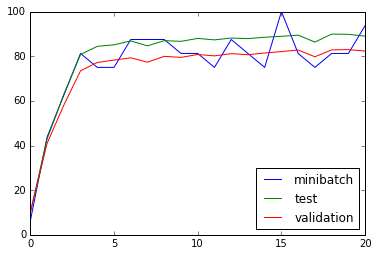

In [48]:
num_steps = 1001

results = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    print('Initialized')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction],
            feed_dict={
                tf_train_dataset : batch_data,
                tf_train_labels : batch_labels
            }
        )
        
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            
            results.append({
                'minibatch': accuracy(predictions, batch_labels),
                'validation': accuracy(valid_prediction.eval(), valid_labels),
                'test': accuracy(test_prediction.eval(), test_labels)
            })
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    
results = pd.DataFrame(results)
results.plot()

## Try different layers

In [63]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
    layer3_weights = tf.Variable(tf.truncated_normal(
      [size3 * size3 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        # Layer 1 (Conv): input 28 x 28
        layer_1_conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
        layer_1_bias = tf.nn.relu(layer_1_conv + layer1_biases)
        
        # Layer 2 (Stride): input 24 x 24
        layer_2_pool = tf.nn.avg_pool(layer_1_bias, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        # Layer 3 (Conv): input 12 x 12
        layer_3_conv = tf.nn.conv2d(layer_2_pool, layer2_weights, [1, 1, 1, 1], padding='VALID')
        layer_3_bias = tf.nn.relu(layer_3_conv + layer2_biases)
        
        # Layer 4 (Stride): input 8 x 8
        layer_4_pool = tf.nn.max_pool(layer_3_bias, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        # Layer 4 (Final): input 4 x 4
        shape = layer_4_pool.get_shape().as_list()
        reshape = tf.reshape(layer_4_pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        return tf.matmul(hidden, layer4_weights) + layer4_biases
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 3.366702
Minibatch loss at step 50: 1.999454
Minibatch loss at step 100: 1.231575
Minibatch loss at step 150: 0.868423
Minibatch loss at step 200: 1.164805
Minibatch loss at step 250: 1.185170
Minibatch loss at step 300: 0.688734
Minibatch loss at step 350: 0.682034
Minibatch loss at step 400: 0.327332
Minibatch loss at step 450: 0.937644
Minibatch loss at step 500: 1.003644
Minibatch loss at step 550: 0.772862
Minibatch loss at step 600: 0.459518
Minibatch loss at step 650: 0.944724
Minibatch loss at step 700: 0.913471
Minibatch loss at step 750: 0.038550
Minibatch loss at step 800: 0.430458
Minibatch loss at step 850: 0.780987
Minibatch loss at step 900: 0.691217
Minibatch loss at step 950: 0.617455
Minibatch loss at step 1000: 0.422513
Minibatch loss at step 1050: 0.481182
Minibatch loss at step 1100: 0.642880
Minibatch loss at step 1150: 0.445649
Minibatch loss at step 1200: 1.032377
Minibatch loss at step 1250: 0.537142
Minibatch loss at step 

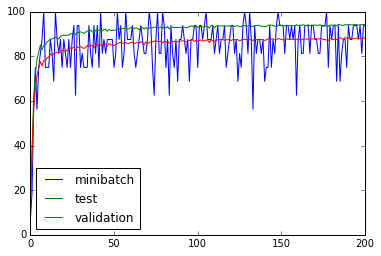

In [65]:
num_steps = 10001

results = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    print('Initialized')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction],
            feed_dict={
                tf_train_dataset : batch_data,
                tf_train_labels : batch_labels
            }
        )
        
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            
            results.append({
                'minibatch': accuracy(predictions, batch_labels),
                'validation': accuracy(valid_prediction.eval(), valid_labels),
                'test': accuracy(test_prediction.eval(), test_labels)
            })
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    
results = pd.DataFrame(results)
results.plot()